In [2]:
!pip install opendatasets --upgrade

Requirement already up-to-date: opendatasets in /usr/local/lib/python3.6/dist-packages (0.1.10)


In [3]:
import os
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import random
import shutil
from PIL import Image

import opendatasets as od
from zipfile import ZipFile

### The Data use in this notebook is from kaggle
### download the data from [kaggle datasets](https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda/download) and unzip using the <i>opendatasets</i> python library
### running the cell below to split data into train and validation sets.
check out the opedatasets documentation below:\
[opendatasets github repo](https://github.com/JovianML/opendatasets)
```
animal-image-datasetdog-cat-and-panda\animals
|____animals
     |___cats
             cat001.jpg
             cat002.jpg
             ...
     |___dogs
             dogs001.jpg
             dogs002.jpg
             ...
     |___panda
             panda001.jpg
             ...
|____images
```
### to...
```
animal-image-datasetdog-cat-and-panda/train/
|____animals
        ...
|____train
    |___cats
             cat071.jpg
             cat813.jpg
             ...
     |___dogs
             dogs431.jpg
             dogs144.jpg
             ...
     |___panda
             panda651.jpg
             ...
|____valid
    |___cats
             cats342.jpg
             cats715.jpg
             ...
     |___dogs
             dogs545.jpg
             dogs114.jpg
             ...
     |___panda
             panda001.jpg
             ...
|___images (test set)
    
```

In [4]:
dataset_url = "https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: mustious
Your Kaggle Key: ··········


  3%|▎         | 11.0M/376M [00:00<00:03, 109MB/s]

100%|██████████| 376M/376M [00:01<00:00, 217MB/s]


In [5]:
ls

animal-image-datasetdog-cat-and-panda/  sample_data/


In [6]:
# image transformations
train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                      ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

In [7]:
animal_datasets = datasets.ImageFolder("animal-image-datasetdog-cat-and-panda/animals/animals", transform=train_transforms)

### Divide the dataset into 80% train set and 20% should consist of validation set

In [8]:
len(animal_datasets)

3000

In [9]:
train_len = int(0.8 * len(animal_datasets))
val_len = len(animal_datasets) - train_len
train_dataset , val_dataset = random_split(animal_datasets, [train_len, val_len])

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

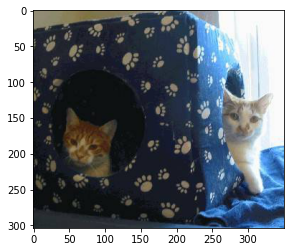

In [11]:
# show a cat random images
train_folder = "animal-image-datasetdog-cat-and-panda/animals/animals/"
cat_folder = os.path.join(train_folder, "cats")
cat_image = random.choice(os.listdir(cat_folder))
image = Image.open(os.path.join(cat_folder, cat_image))
plt.imshow(image)

In [12]:
animal_key = {0: "cat", 1: "dog", 2: "panda"}

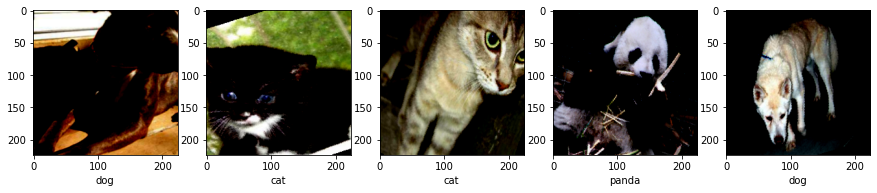

In [25]:
# displaying more images including their labels
some_images, some_labels = next(iter(train_loader))
figs, axes = plt.subplots(figsize=(15,5), ncols=5)
for i in range(5):
    image = some_images[i].numpy().transpose((1,2,0))
    label = int(some_labels[i].numpy())
    image = np.clip(image, 0, 1)
    ax = axes[i]
    ax.imshow(image)
    ax.set_xlabel(animal_key[label])

In [26]:
# using a pretrained model for feature extraction
densenet_model = models.densenet161(pretrained=True)

In [27]:
densenet_model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [28]:
# freezing the pretrained weights
for params in densenet_model.parameters():
    params.requires_grad = False

In [29]:
# creating the classifier model
my_classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2208, 500)),
                                           ('dropout1', nn.Dropout(p=0.4)),
                                           ('relu1', nn.ReLU()),
                                           ('fc2', nn.Linear(500, 64)),
                                           ('relu2', nn.ReLU()),
                                           ('dropout2', nn.Dropout(p=0.3)),
                                           ('fc3', nn.Linear(64, 3)),
                                           ('output', nn.LogSoftmax(dim=1))
                                          ]))

In [30]:
densenet_model.classifier = my_classifier

In [31]:
# loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=0.00005)

In [37]:
# number of epochs
epochs = 10

In [38]:
# checking device if GPU is avaible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [39]:
all_training_loss, all_val_loss, all_val_accuracy = [], [], []

In [40]:
# move model to GPU if available
densenet_model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [41]:
for epoch in range(epochs):
    training_loss = 0
    val_loss = 0
    val_accuracy = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = densenet_model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        training_loss += loss.item()
        optimizer.step()
    else:
        # entering evaluation mode
        densenet_model.eval()
        
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                log_ps = densenet_model.forward(val_images)
                ps = torch.exp(log_ps)
                batch_val_loss = criterion(log_ps, val_labels)
                val_loss += batch_val_loss.item()
                
                top_p, top_class = ps.topk(k=1, dim=1)
                accuracy_array = top_class == val_labels.view(*top_class.shape)
                accuracy = torch.mean(accuracy_array.type(torch.FloatTensor))
                val_accuracy += accuracy.item()
        
        some_log = f"Training loss: {val_loss/len(train_loader):.4f}\t Validation loss {val_loss/len(val_loader):.4f}\t"
        some_log += f"Validation accuracy: {val_accuracy/len(val_loader):.4f}"
        print(some_log)
        
        all_training_loss.append(training_loss/len(train_loader))
        all_val_loss.append(val_loss/len(val_loader))
        all_val_accuracy.append(val_accuracy/len(val_loader))
        
        densenet_model.train()

Training loss: 0.1499	 Validation loss 0.5915	Validation accuracy: 0.9594
Training loss: 0.0622	 Validation loss 0.2455	Validation accuracy: 0.9649
Training loss: 0.0443	 Validation loss 0.1747	Validation accuracy: 0.9512
Training loss: 0.0341	 Validation loss 0.1345	Validation accuracy: 0.9682
Training loss: 0.0276	 Validation loss 0.1091	Validation accuracy: 0.9688
Training loss: 0.0306	 Validation loss 0.1207	Validation accuracy: 0.9567
Training loss: 0.0254	 Validation loss 0.1001	Validation accuracy: 0.9627
Training loss: 0.0216	 Validation loss 0.0853	Validation accuracy: 0.9748
Training loss: 0.0208	 Validation loss 0.0822	Validation accuracy: 0.9671
Training loss: 0.0200	 Validation loss 0.0789	Validation accuracy: 0.9737


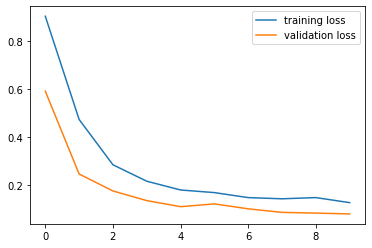

In [42]:
# plotting losses and accuracies
plt.plot(all_training_loss, label="training loss")
plt.plot(all_val_loss, label="validation loss")
#plt.plot(all_test_accuracy, label="testing accuracy")
plt.legend()

In [43]:
# testing model on new images

In [44]:
test_data_path = os.path.join("animal-image-datasetdog-cat-and-panda/images/")

In [45]:
image_list = os.listdir(test_data_path)
image_list

['cat.jpg', 'dog.jpg', 'panda.jpg']

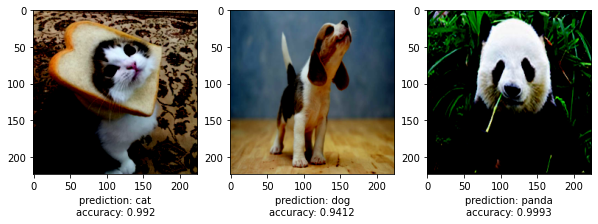

In [46]:
n_test_images = len(image_list)
figs, axes = plt.subplots(figsize=(10,4), ncols=n_test_images)
for i in range(n_test_images):
    ax = axes[i]
    image_PIL = Image.open(os.path.join(test_data_path, image_list[i]))
    image_transformed = test_transforms(image_PIL)
    with torch.no_grad():
        densenet_model.eval()
        densenet_model.to("cpu")
        image_transformed = image_transformed.view((1,3,224,224))
        log_ps = densenet_model.forward(image_transformed)
        ps = torch.exp(log_ps)
        prob, prediction = ps.topk(k=1, dim=1)
        prediction = prediction.item()
        prob = prob.item()
    image = image_transformed.view((3, 224, 224)).numpy().transpose((1,2,0))
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_xlabel("prediction: {}\naccuracy: {:.4}".format(animal_key[prediction], prob))

## Summary
1. A densenet161 was used as a feature extractor
2. A three fully-connected layer neural network was used as the final classifer to learn to classifier between cats, dogs and pandas
3. The performance of the modified densenet model showed amazing results owing to the fact it has been pretrained to extract meaningful features from images